In [1]:
import Pkg; Pkg.add(["Plots","Interact"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/Project.toml`
  No Changes to `~/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false);
using Printf;
using Interact;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

### Warmup

How much work does it take to apply one iteration of the QR algorithm to a tridiagonal matrix?

# Other Eigenvalue Algorithms & SVD Algorithms

**1. The Jacobi algorithm**

**2. Bisection**

**3. Divide-and-conquer**

**4. The SVD**

## The Jacobi algorithm for symmetric matrices

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/jacobi_eig.gif")
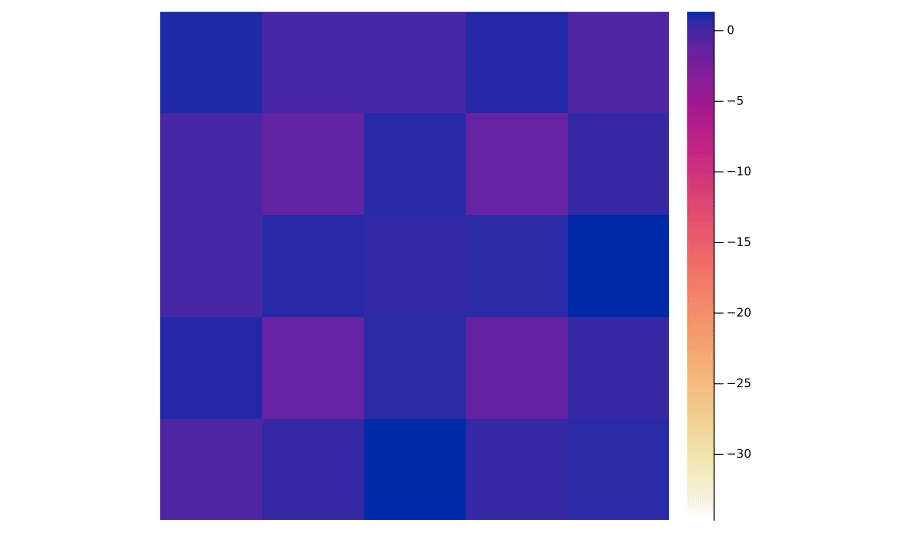

In [4]:
m = 5
A = randn(m,m)
A = A + A'
scale = maximum(abs.(A))
function jacobi_show(A)
    m, n = size(A)
    return imshowlog(A, clim=(log(scale*eps()), log(scale)), xlim=(0.5,n+0.5),ylim=(0.5,m+0.5))
end
n_iter = m^3
anim = Animation()
frame(anim, jacobi_show(A))
for i in 1:n_iter
    plt = jacobi_show(A)
    index = argmax(abs.(A - Diagonal(A)))
    i = index[1]
    j = index[2]
    B = A[[i,j],[i,j]]
    a = B[1,1]
    b = B[2,2]
    d = B[1,2]
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    frame(anim, plt)
    θ = atan(2 * d, b - a) / 2
    c = cos(θ)
    s = sin(θ)
    J = [c s ; -s c]
    A[[i,j],:] = J' * A[[i,j],:]
    A[:,[i,j]] = A[[i,j],:]'
    A[[i,j],[i,j]] = J' * B * J
    plt = jacobi_show(A)
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    frame(anim, plt)
    newscale = maximum(abs.(A - Diagonal(A)))
    if newscale <= eps() * scale
        break
    end
end

gif(anim, "jacobi_eig.gif", fps=1)

- Given a $2 \times 2$ symmetric matrix

  $$B = \begin{bmatrix} a & d \\ d & b \end{bmatrix},$$
  
  an orthogonal _rotation matrix_
  
  $$J = \begin{bmatrix} \cos(\theta) & \sin(\theta) \\ - \sin(\theta) & \cos(\theta) \end{bmatrix}$$
  
  diagonalizes $B$ if $\tan(2\theta) = \frac{2d}{b-a}.$

- Apply a Jacobi rotation to zero off-diagonal entries.  Subsequent rotations will reintroduce nonzeros.  If we always target the largest off-diagonal entry, we see the magnitudes decline.  Provably?

### Jacobi algorithm convergence (T&B Exercise 30.3)

Assume that we are applying Jacobi Algorithm to matrix $A$. At each step, we perform a unitary transformation on $A$, therefore the Frobenius norm of $A$ will not change.

$$\|A\|_F^2=\sum |a_{ij}|^2==F_d+F_o,F_d=\sum_{i=j}|a_{ij}|^2,F_o=\sum_{i\neq j}|a_{ij}|^2$$

Denote $d$ as the largest off-diagonal components, we have:

$$F_d^{(k+1)}=F_d^{(k)}+2|d|^2,F_o^{(k+1)}=F_o^{(k)}-2|d|^2$$

Cause $d$ is the largest off-diagonal components, and there are total $m(m-1)$ off-diagonal components:

$$|d|^2\geq F_o^{(k)}\frac{1}{m(m-1)}\Rightarrow F_o^{(k+1)} \leq F_o^{(k)} (1 - \frac{2}{m(m-1)})$$

______

- Every rotation is a unitary transformation, 
_preserving the Frobenius norm_, $\|A\|_F^2 = \sum_{i,j} |a_{i,j}|^2.$

- Break down the Frobenius norm into diagonal and off diagonal components, $$\underbrace{\sum_{i} |a_{i,i}|^2}_{F_d} + \underbrace{2\sum_{j > i} |a_{i,j}|^2}_{F_o}.$$

- $F_d^{(k+1)} \gets F_d^{(k)} + 2d^2$,  $F_o^{(k+1)} \gets F_o^{(k)} - 2d^2$

- But $d$ was the largest off-diagonal components, so $F_o^{(k+1)} \leq F_o^{(k)} (1 - \frac{2}{m(m-1)})$

This proves linear convergence of $F_o$ to 0.  In fact, in can be shown that convergence is quadratic.

### Convergence is also quadaratic for elimination in order

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/jacobi_eig2.gif")
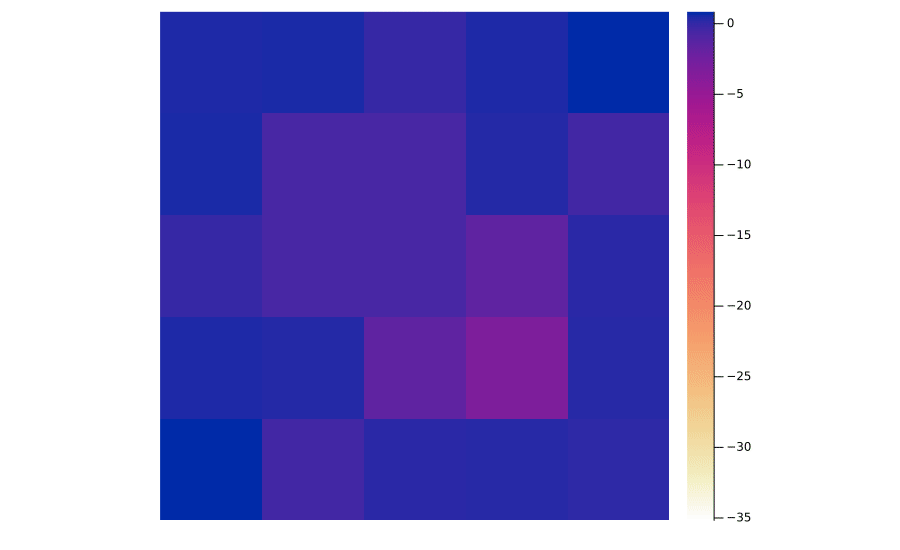

In [5]:
m = 5
A = randn(m,m)
A = A + A'
scale = maximum(abs.(A))
function jacobi_show(A)
    m, n = size(A)
    return imshowlog(A, clim=(log(scale*eps()), log(scale)), xlim=(0.5,n+0.5),ylim=(0.5,m+0.5))
end
n_iter = m^3
anim = Animation()
frame(anim, jacobi_show(A))
i = 1
j = 2
for k in 1:n_iter
    plt = jacobi_show(A)
    B = A[[i,j],[i,j]]
    a = B[1,1]
    b = B[2,2]
    d = B[1,2]
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    frame(anim, plt)
    θ = atan(2 * d, b - a) / 2
    c = cos(θ)
    s = sin(θ)
    J = [c s ; -s c]
    A[[i,j],:] = J' * A[[i,j],:]
    A[:,[i,j]] = A[[i,j],:]'
    A[[i,j],[i,j]] = J' * B * J
    plt = jacobi_show(A)
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    frame(anim, plt)
    if j == m
        i += 1
        j = i + 1
        if i == m
            i = 1
            j = 2
        end
    else
        j += 1
    end
end

gif(anim, "jacobi_eig2.gif", fps=2)

### There is no point in tridiagonalizing at the start

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/jacobi_eig3.gif")
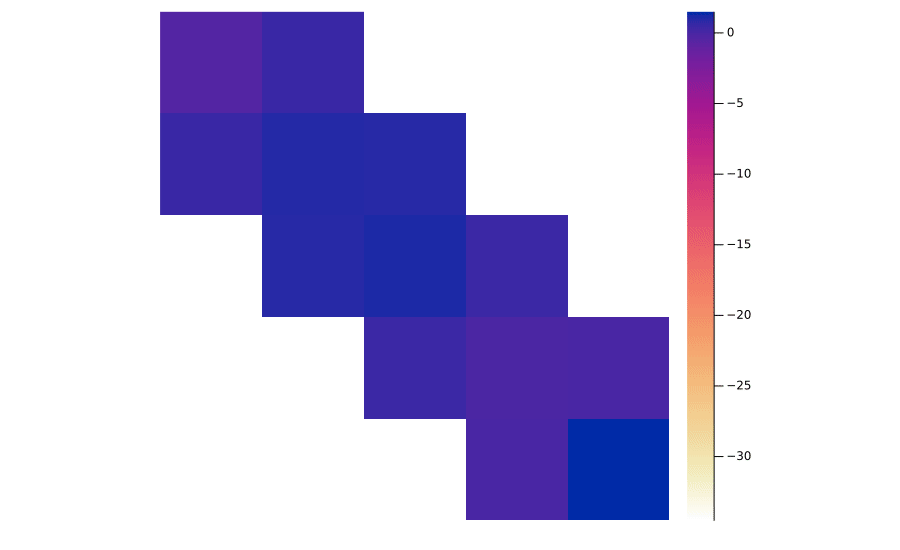

In [6]:
m = 5
A = randn(m,m)
A = A + A'
A = Matrix(Tridiagonal(hessenberg(A).H))
scale = maximum(abs.(A))
function jacobi_show(A)
    m, n = size(A)
    return imshowlog(A, clim=(log(scale*eps()), log(scale)), xlim=(0.5,n+0.5),ylim=(0.5,m+0.5))
end
n_iter = m^3
anim = Animation()
frame(anim, jacobi_show(A))
for i in 1:n_iter
    plt = jacobi_show(A)
    index = argmax(abs.(A - Diagonal(A)))
    i = index[1]
    j = index[2]
    B = A[[i,j],[i,j]]
    a = B[1,1]
    b = B[2,2]
    d = B[1,2]
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    frame(anim, plt)
    θ = atan(2 * d, b - a) / 2
    c = cos(θ)
    s = sin(θ)
    J = [c s ; -s c]
    A[[i,j],:] = J' * A[[i,j],:]
    A[:,[i,j]] = A[[i,j],:]'
    A[[i,j],[i,j]] = J' * B * J
    plt = jacobi_show(A)
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    frame(anim, plt)
    newscale = maximum(abs.(A - Diagonal(A)))
    if newscale <= eps() * scale
        break
    end
end

gif(anim, "jacobi_eig3.gif", fps=2)

### Jacobi rotations can be parallelized somewhat

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/jacobi_eig4.gif")
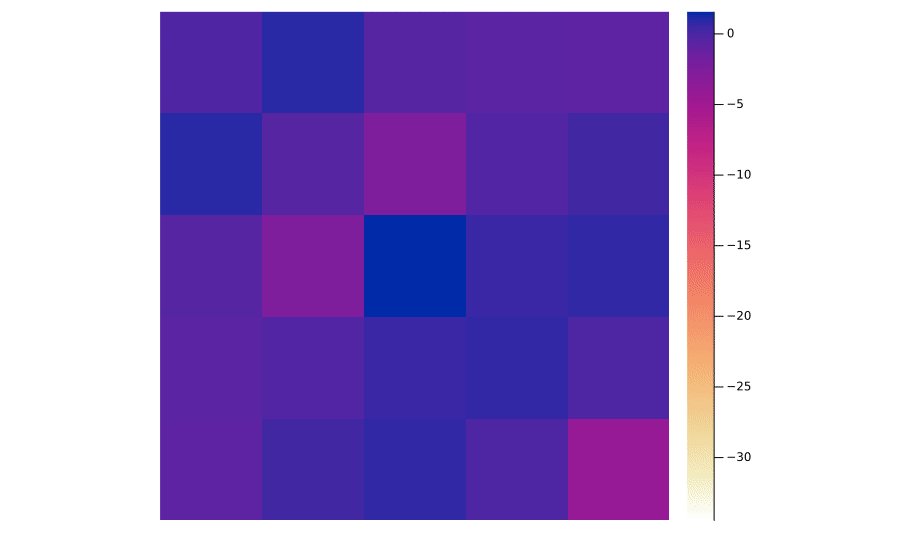

In [7]:
m = 5
A = randn(m,m)
A = A + A'
scale = maximum(abs.(A))
function jacobi_show(A)
    m, n = size(A)
    return imshowlog(A, clim=(log(scale*eps()), log(scale)), xlim=(0.5,n+0.5),ylim=(0.5,m+0.5))
end
n_iter = m^3
anim = Animation()
frame(anim, jacobi_show(A))
pairs = [((1,5),(2,4)), ((1,4),(2,3)), ((2,5),(3,4)), ((1,3),(4,5)), ((1,2), (3,5))]
for k in 1:n_iter
    plt = jacobi_show(A)
    i,j = pairs[mod(k-1,5)+1][1]
    i2,j2 = pairs[mod(k-1,5)+1][2]
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [j2-0.5,j2+0.5,j2+0.5,j2-0.5,j2-0.5], [i2-0.5,i2-0.5,i2+0.5,i2+0.5,i2-0.5], c=4)
    plot!(plt, [i2-0.5,i2-0.5,i2+0.5,i2+0.5,i2-0.5], [j2-0.5,j2+0.5,j2+0.5,j2-0.5,j2-0.5], c=4)
    plot!(plt, [i2-0.5,i2-0.5,i2+0.5,i2+0.5,i2-0.5], [i2-0.5,i2+0.5,i2+0.5,i2-0.5,i2-0.5], c=4)
    plot!(plt, [j2-0.5,j2-0.5,j2+0.5,j2+0.5,j2-0.5], [j2-0.5,j2+0.5,j2+0.5,j2-0.5,j2-0.5], c=4)
    frame(anim, plt)
    B = A[[i,j],[i,j]]
    a = B[1,1]
    b = B[2,2]
    d = B[1,2]
    θ = atan(2 * d, b - a) / 2
    c = cos(θ)
    s = sin(θ)
    J = [c s ; -s c]
    A[[i,j],:] = J' * A[[i,j],:]
    A[:,[i,j]] = A[[i,j],:]'
    A[[i,j],[i,j]] = J' * B * J
    
    B = A[[i2,j2],[i2,j2]]
    a = B[1,1]
    b = B[2,2]
    d = B[1,2]
    θ = atan(2 * d, b - a) / 2
    c = cos(θ)
    s = sin(θ)
    J = [c s ; -s c]
    A[[i2,j2],:] = J' * A[[i2,j2],:]
    A[:,[i2,j2]] = A[[i2,j2],:]'
    A[[i2,j2],[i2,j2]] = J' * B * J
    
    plt = jacobi_show(A)
    plot!(plt, [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [i-0.5,i-0.5,i+0.5,i+0.5,i-0.5], [i-0.5,i+0.5,i+0.5,i-0.5,i-0.5], c=3)
    plot!(plt, [j-0.5,j-0.5,j+0.5,j+0.5,j-0.5], [j-0.5,j+0.5,j+0.5,j-0.5,j-0.5], c=3)
    plot!(plt, [j2-0.5,j2+0.5,j2+0.5,j2-0.5,j2-0.5], [i2-0.5,i2-0.5,i2+0.5,i2+0.5,i2-0.5], c=4)
    plot!(plt, [i2-0.5,i2-0.5,i2+0.5,i2+0.5,i2-0.5], [j2-0.5,j2+0.5,j2+0.5,j2-0.5,j2-0.5], c=4)
    plot!(plt, [i2-0.5,i2-0.5,i2+0.5,i2+0.5,i2-0.5], [i2-0.5,i2+0.5,i2+0.5,i2-0.5,i2-0.5], c=4)
    plot!(plt, [j2-0.5,j2-0.5,j2+0.5,j2+0.5,j2-0.5], [j2-0.5,j2+0.5,j2+0.5,j2-0.5,j2-0.5], c=4)
    frame(anim, plt)
end

gif(anim, "jacobi_eig4.gif", fps=2)

## Bisection for hermitian tridiagonal matrices

Since the eigenvalues of a hermitian matrix are real, we can find them by searching the real line for roots of the polynomial $p(x) = \det(A - xI)$.

- The real line is ordered.  Searching an ordered set is fast, right?

- We know that evaluating a polynomial from its coefficients is unstable, but we will evaluate $p(x)$ implicitly.

- For a hermitian tridiagonal matrix, these are fast:

  - evaluating $p(x)$
  
  - determining how many eigenvalues are in an interval $(a, b)$

### Critical property of hermitian matrices: eigenvalue interlacing

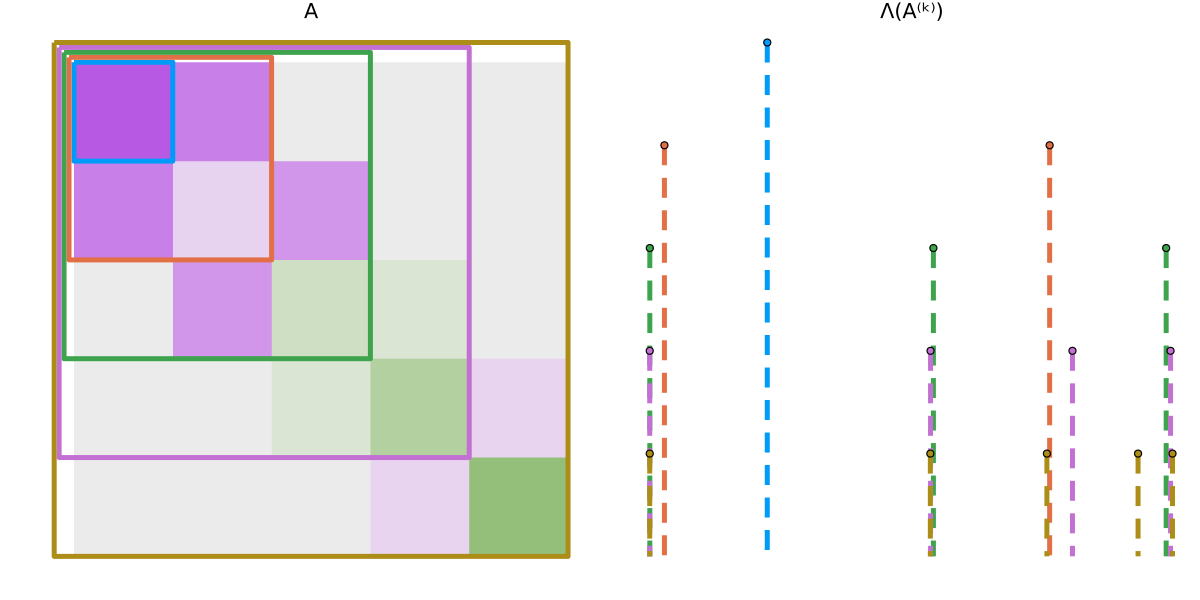

In [8]:
m = 5

A = randn(m,m)
A = A + A'
A = Matrix(Tridiagonal(hessenberg(A).H))
scale = maximum(abs.(A))
p = imshow(A, clim=(-scale,scale), colorbar=false, title="A")
for i in 1:m
    plot!(p, [0.5-(i-1)*0.05, i+0.5, i+0.5, 0.5-(i-1)*0.05, 0.5-(i-1)*0.05], [0.5-(i-1)*0.05, 0.5-(i-1)*0.05, i+0.5, i+0.5, 0.5-(i-1)*0.05], c=i)
end
q = plot(title="Λ(A⁽ᵏ⁾)", framestyle=:none, yflip = true)
for i in 1:m
    v = eigvals(A[1:i,1:i])
    for val in v
        plot!(q, [val,val], [i,m+1], l=(:dash), c=i)
    end
    plot!(q, v, i*ones(i), st=:scatter, c=i)
end
plot(p, q, layout=(1,2), size=(1200,600))

### Theorem

If $A$ is a hermitian tridiagonal matrix with all nonzeros on the super/subdiagonal, then the eigenvalues of $A$ are distinct and they _strictly interlace_ with the eigenvalues of $A_{m-1} = A_{1:m-1,1:m-1}$.

### Query: how many eigenvalues are < 0?

Count on each side changes by at most one at each level

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/bisection_parity.gif")
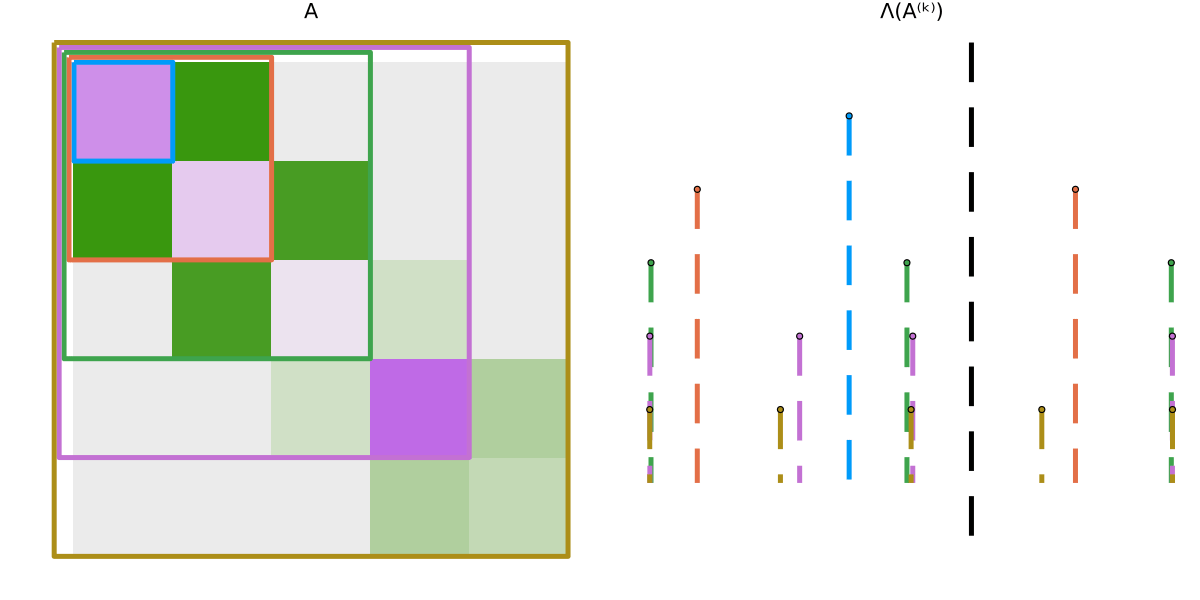

In [9]:
m = 5

Λ = LinRange(-m-3,m,m)
Q = qr(randn(m,m)).Q
A = Q * diagm(Λ) * Q'
A = Matrix(Tridiagonal(hessenberg(A).H))
scale = maximum(abs.(A))
p = imshow(A, clim=(-scale,scale), colorbar=false, title="A")
for i in 1:m
    plot!(p, [0.5-(i-1)*0.05, i+0.5, i+0.5, 0.5-(i-1)*0.05, 0.5-(i-1)*0.05], [0.5-(i-1)*0.05, 0.5-(i-1)*0.05, i+0.5, i+0.5, 0.5-(i-1)*0.05], c=i)
end
q = plot(title="Λ(A⁽ᵏ⁾)", framestyle=:none, yflip = true)
for i in 1:m
    v = eigvals(A[1:i,1:i])
    for val in v
        plot!(q, [val,val], [i,m+1], l=(:dash), c=i)
    end
    plot!(q, v, i*ones(i), st=:scatter, c=i)
end
plot!(q, [0,0], [0, m+2], l=(:dash), c=:black)
anim = Animation()
frame(anim, plot(p, q, layout=(1,2), size=(1200,600)))
for i in 1:m
    v = eigvals(A[1:i,1:i])
    lt = sum(v .< 0)
    gt = sum(v .>= 0)
    annotate!(q, -0.5,i, "$lt")
    annotate!(q, 0.5,i, "$gt")
    frame(anim, plot(p, q, layout=(1,2), size=(1200,600)))
end
gif(anim, "bisection_parity.gif", fps=0.5)

### $\Rightarrow$ if $\mathrm{sign}(\det(A_k)) \neq \mathrm{sign}(\det(A_{k-1}))$, there is one additional negative eigenvalue

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/bisection_det.gif")
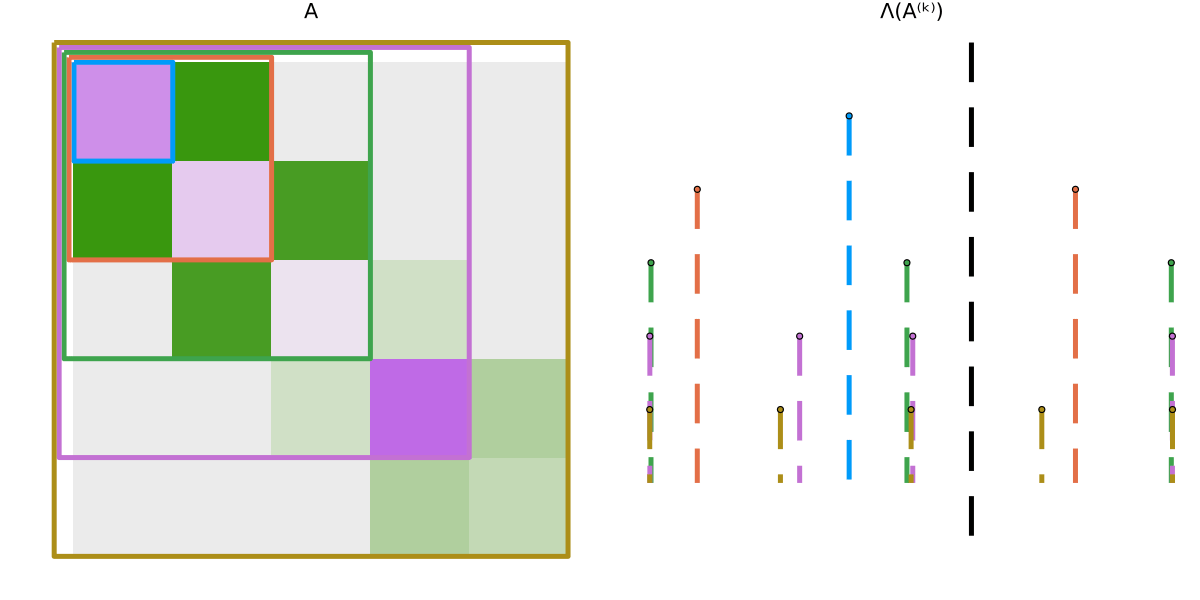

In [10]:
scale = maximum(abs.(A))
p = imshow(A, clim=(-scale,scale), colorbar=false, title="A")
for i in 1:m
    plot!(p, [0.5-(i-1)*0.05, i+0.5, i+0.5, 0.5-(i-1)*0.05, 0.5-(i-1)*0.05], [0.5-(i-1)*0.05, 0.5-(i-1)*0.05, i+0.5, i+0.5, 0.5-(i-1)*0.05], c=i)
end
q = plot(title="Λ(A⁽ᵏ⁾)", framestyle=:none, yflip = true)
for i in 1:m
    v = eigvals(A[1:i,1:i])
    for val in v
        plot!(q, [val,val], [i,m+1], l=(:dash), c=i)
    end
    plot!(q, v, i*ones(i), st=:scatter, c=i)
end
plot!(q, [0,0], [0, m+2], l=(:dash), c=:black)
anim = Animation()
frame(anim, plot(p, q, layout=(1,2), size=(1200,600)))
last = sign(1)
total = 0
for i in 1:m
    d = det(A[1:i,1:i])   
    if d < 0
        annotate!(q, -0.5, i, "<")
        if sign(d) != last
            annotate!(q, -1, i, "+1")
        end
    else
        annotate!(q, 0.5, i, ">")
        if sign(d) != last
            annotate!(q, 1, i, "+1")
        end
    end
    last = sign(d)
    frame(anim, plot(p, q, layout=(1,2), size=(1200,600)))
end
frame(anim, plot(p, q, layout=(1,2), size=(1200,600)))
gif(anim, "bisection_det.gif", fps=0.5)

- We can determine how many eigenvalues are in $(-\infty,0)$ and $[0, \infty)$

- We can determine how many eigenvalues are in $(-\infty,\alpha)$ and $[\alpha, \infty$) by running bisection on $A - \alpha I$

- With two bisections we can deduce how many eigenvalues are in $[a, b)$ for any finite interval

### Computing the determinant of a hermitian tridiagonal matrix

Let

$$
A = \begin{bmatrix}
a_1 & b_1 & & \\
\bar{b}_1 & a_2 & b_2 & \\
& \bar{b}_2 & \ddots & \ddots \\
& & \ddots & \ddots & b_{m-1} \\
& & & \bar{b}_{m-1} & a_m
\end{bmatrix}
$$

and

$$
p^{(k)}(x) = \det(A^{(k)} - x I)
$$

Then $p^{(k)}$ can be evaluated by a **three term recurrence:**

$$\begin{aligned}
p^{(-1)}(x) &:= 0 \\
p^{(0)}(x) &:= 1 \\
&\vdots \\
p^{(k)}(x) &= (a_k - x) p^{(k-1)}(x) - |b_{k-1}|^2 p^{(k-2)}(x).
\end{aligned}
$$

$\Rightarrow O(m)$ work per bisection evaluation.

$\Rightarrow$ $O(m \log(\epsilon_{\text{machine}}))$ work to determine all eigenvalues to relative accuracy $\epsilon_{\text{machine}}$.

## Divide-and-Conquer for real symmetric tridiagonal matrices

$$
T = \begin{bmatrix}
a_1 & b_1 & & \\
b_1 & a_2 & b_2 & \\
& b_2 & \ddots & \ddots \\
& & \ddots & \ddots & b_{m-1} \\
& & & b_{m-1} & a_m
\end{bmatrix},
$$

and we assume all $b_k$ are nonzero.

$$
T = 
\left[
\begin{array}{ccc|ccc}
\\
& T_1 \\
& & & \beta \\ \hline
& & \beta \\
& & & & T_2 & \\
\\
\end{array}
\right]
=
\left[
\begin{array}{ccc|ccc}
\\
& \hat T_1 \\
& & & \\ \hline
& &  \\
& & & & \hat T_2 & \\
\\
\end{array}
\right]
+
\left[
\begin{array}{ccc|ccc}
\\
\\
& & \beta & \beta \\ \hline
& & \beta & \beta \\
& & & &  & \\
\\
\end{array}
\right]
$$

This is a rank one update:

$$
=
\left[
\begin{array}{ccc|ccc}
\\
& \hat T_1 \\
& & & \\ \hline
& &  \\
& & & & \hat T_2 & \\
\\
\end{array}
\right]
+
\beta
\left[
\begin{array}{ccc|ccc}
\\
& e_{m/2}e_{m/2}^* & & & e_{m/2} e_1^* \\
& & & \\ \hline
& &  \\
& e_1 e_{m/2}^* & & & e_1 e_1^* & \\
\\
\end{array}
\right]
$$
$$
=
\left[
\begin{array}{ccc|ccc}
\\
& \hat T_1 \\
& & & \\ \hline
& &  \\
& & & & \hat T_2 & \\
\\
\end{array}
\right]
+
\beta
\begin{bmatrix} \\ e_{m/2} \\ \\ \hline \\ e_1 \\ {}
\end{bmatrix}
\left[
\begin{array}{ccc|ccc}
& e_{m/2}^* & & & e_1^* &
\end{array}
\right]
$$

$$
=
\left[
\begin{array}{ccc|ccc}
\\
& Q D_1 Q^* \\
& & & \\ \hline
& &  \\
& & & & U D_2 U^* & \\
\\
\end{array}
\right]
+
\beta
\begin{bmatrix} \\ e_{m/2} \\ \\ \hline \\ e_1 \\ {}
\end{bmatrix}
\left[
\begin{array}{ccc|ccc}
& e_{m/2}^* & & & e_1^* &
\end{array}
\right]
$$

$$
=
\left[
\begin{array}{c|c}
Q \\ \hline
& U
\end{array}
\right]
\left(
\left[
\begin{array}{c|c}
D_1 \\ \hline
& D_2
\end{array}
\right]
+
\beta
\begin{bmatrix} Q^* e_{m/2} \\ \hline U^* e_1 
\end{bmatrix}
\left[
\begin{array}{c|c}
(Q^*e_{m/2})^* & (U^*e_1)^*
\end{array}
\right]
\right)
\left[
\begin{array}{c|c}
Q^* \\ \hline
& U^*
\end{array}
\right]
$$

Letting $q_{m/2}$ be the last _row_ of $Q$ and $u_1$ be the first _row_ of $U$, 

$$T
=
\left[
\begin{array}{c|c}
Q \\ \hline
& U
\end{array}
\right]
\underbrace{
\left(
\left[
\begin{array}{c|c}
D_1 \\ \hline
& D_2
\end{array}
\right]
+
\beta
\begin{bmatrix} q_{m/2} \\ \hline u_1 
\end{bmatrix}
\left[
\begin{array}{c|c}
q_{m/2}^* & u_1^* 
\end{array}
\right]
\right)}_{\large = D + w w^*}
\left[
\begin{array}{c|c}
Q^* \\ \hline
& U^*
\end{array}
\right]
$$

$\Rightarrow$ we can quickly combine the submatrix eigenvalue decompositions if we can **quickly compute the eigendecomposition of a rank-one update to a diagonal matrix**.

**Claim.** If the diagonal elements of $D$ are distinct and all elements of $w$ are nonzero, then the eigenvalues of $D + ww^*$ are the roots of the rational equation

$$
f(\lambda) = 1 + \sum_{j=1}^m \frac{w_j^2}{d_j - \lambda}.
$$



### $f(\lambda) = 0$: the secular equation

The wild behavior for random $w$'s should indicate that we must be careful to find roots in a numerically stable way, but each root can usually be found in $O(1)$ steps, with $O(m)$ work per step $\Rightarrow O(m^2)$ work to find all eigenvalues.

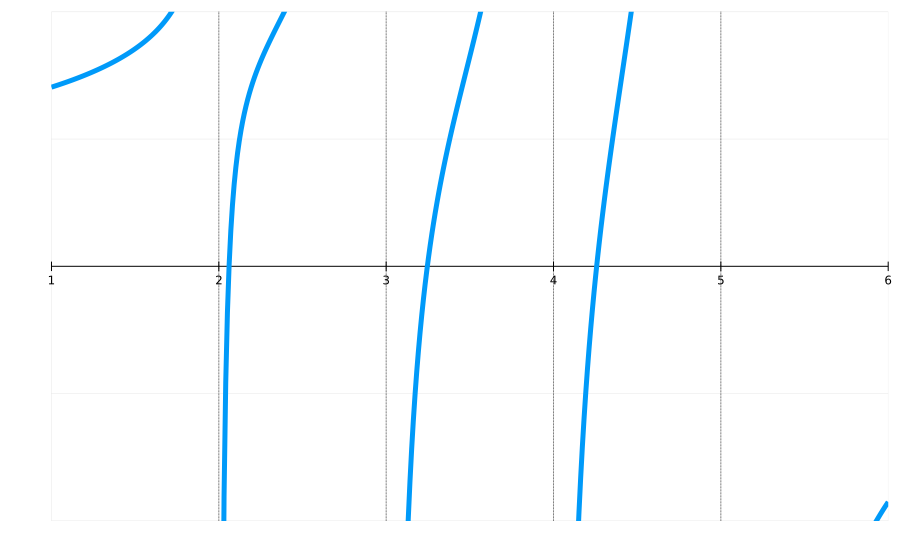

In [11]:
m = 4
D = LinRange(2, 5, m)
w = randn(m)
f(λ) = 1 + sum(abs.(w).^2 ./ (D .- λ))
p = plot(framestyle=:origin, xlim=(1, 6), ylim=(-5,5))
for i in 1:m
    plot!(p, [D[i], D[i]], [-5, 5], l=(1, :dot), c=:black)
end
x = LinRange(1,2-0.001,100)
y = f.(x)
plot!(p,x,y,c=1)
for i in 2:4
    x = LinRange(i+0.001,i+1-0.001,100)
    y = f.(x)
    plot!(p,x,y,c=1)
end
x = LinRange(5+0.001,6,100)
y = f.(x)
plot!(p,x,y,c=1)
p

### Work to compute eigenvalues: sum over recursive levels

$$
O\left(m^2
+ 
2 \left(
\frac{m}{2}
\right)^2
+ 
4 \left(
\frac{m}{4}
\right)^2
+ 
8 \left(
\frac{m}{8}
\right)^2
+
\cdots
+
m \left(
\frac{m}{m}
\right)^2
\right)
$$
$$
=
O\left(m^2
\left(
1 + \frac{1}{2} + \frac{1}{4} + \frac{1}{8} + \cdots + \frac{1}{m}
\right)
\right)
$$
$$
=
O(m^2)
$$

- The work to compute _just the eigenvalues_ with the QR algorithm is also $O(m^2)$ ($O(m)$ iterations at $O(m)$ work per iteration).  There is not a big advantage to using divide-and-conquer here.

- Both are dominated by the $\sim \frac{4}{3} m^3$ work to transform a matrix to tridiagonal form in phase 1

### Computing the eigenvectors $Q$

- Phase 1 transformation to tridiagonal: now $\sim 8/3 m^3$ because the initial tranformatin $Q_0$ is formed,

- **QR Algorithm:** $\approx 6 m^3$ from

$$\underline{Q}^{(k)} = Q^{(1)} Q^{(2)} \cdots Q^{(k)}$$

- **Divide-and-Conquer:** $\sim \frac{4}{3}m^3$ from recursive multiplications by $Q$ and $U$

## SVD Computation

### SVD of $A$ and Eigenvalues of $A^*A$

We have known since the start of class that if $A^* A = V \Lambda V^*$, then $\Sigma = \sqrt{\Lambda}$

- Final step, solve $U \Sigma = A V$ (by QR factorization)

Using a stable algorithm to compute $B = A^*A = V \Lambda V^*$,

$$\tilde{V} \tilde{\Lambda} \tilde{V}^* = B + \delta B, \quad \frac{\|\delta B \|}{\|B\|} = O(\epsilon_{\text{machine}})$$

_Each_ eigenvector $\tilde{\lambda}_k$ has error bounded by $\|\delta B\|$,

$$|\tilde{\lambda}_k - \lambda_k| = O(\|\delta B\|) = O(\|B\| \epsilon_{\text{machine}}) = O(\|A\|^2 \epsilon_{\text{machine}})$$

$\Rightarrow$ error of singular value $k$,

$$|\tilde{\sigma}_k - \sigma_k| = O(\frac{|\tilde{\lambda}_k - \lambda_k|}{\sqrt{\lambda_k}})
= O(\epsilon_{\text{machine}}\frac{\|A\|^2}{\sigma_k})$$

Compare this to the error between  $\tilde \sigma_k = \sigma_k(A + \delta A)$ and $\sigma_k$ from a backward stable algorithm:

$$|\tilde \sigma_k - \sigma_k| = O(\|\delta A\|) = O(\epsilon_{\text{machine}} \|A\|).$$

- Errors in $\sigma_1$ are same order of magnitude

- Errors in smallest singular value loses accuracy by a factor of $\kappa(A)$

### A different reduction to an eigenvalue problem

$$
H = \begin{bmatrix} 0 & A^* \\ A & 0 \end{bmatrix}
$$

$$
\begin{bmatrix} 0 & A^* \\ A & 0 \end{bmatrix}
\begin{bmatrix} V & V \\ -U & U \end{bmatrix} = 
\begin{bmatrix} V & V \\ -U & U \end{bmatrix}
\begin{bmatrix} \Sigma & \\ & -\Sigma \end{bmatrix}
$$

$O(\|H\|) = O(\|A\|)$, so a stable eigenvalue decomposition algorithm is a stable SVD algorithm

If $A$ is square, $(2m)^3 = 8m^3$: it is expensive to form $H$ and perform eigendecomposition directly.

### Two Phases

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{1: } A \gets U_0^* A V_0}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times &  &  &  \\
& \times & \times &  &  \\
& & \times & \times &  \\
& & & \times & \times \\
& & & & \times \\
\\
\\
\end{bmatrix}}_{H}
\quad
\stackrel{\text{2: } U_k^* U_{k-1}^* \cdots U_1^* A V_1 \cdots V_k V_{k-1}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times &  &  &  &  \\
& \times & &  &  \\
& & \times &  &  \\
& & & \times &  \\
& & & & \times \\
\\
\\
\end{bmatrix}}_{\Sigma}
$$


1. **Bidiagonalization** 
2. Iterative diagonalization

Different from eigenvalue algorithms because there are different unitary transformations on the left and the right

## Bidiagonalization

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{1: } A \gets U_0^* A V_0}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times &  &  &  \\
& \times & \times &  &  \\
& & \times & \times &  \\
& & & \times & \times \\
& & & & \times \\
\\
\\
\end{bmatrix}}_{H}
$$

- Accomplish by different householder reflectors on the left and the right, but which order introduce zeros affects to number of flops.  Depending on the algorithm, the work is

$$\sim 4mn^2 - \frac{4}{3}n^3 - \frac{2}{3}(m-n)^3 = O(\min\{4mn^2 - \frac{4}{3}n^3, 2mn^2 + 2n^3\}).$$

### Phase 2

$$
\underbrace{\begin{bmatrix}
\times & \times &  &  &  \\
& \times & \times &  &  \\
& & \times & \times &  \\
& & & \times & \times \\
& & & & \times \\
\\
\\
\end{bmatrix}}_{H}
\quad
\stackrel{\text{2: } U_k^* U_{k-1}^* \cdots U_1^* A V_1 \cdots V_k V_{k-1}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times &  &  &  &  \\
& \times & &  &  \\
& & \times &  &  \\
& & & \times &  \\
& & & & \times \\
\\
\\
\end{bmatrix}}_{\Sigma}
$$

This is equivalent to diagonalizing a tridiagonal matrix.  There are equivalent algorithms to the QR algorithm
and divide-and-conquer.